In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from skimage.io import imread
import skimage.feature

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.colors as mcolors
np.random.seed(42)


In [3]:
a = [1,4,6]
b = [2,1,5]
np.argmax(b)

2

# 导入图像

In [4]:
from utils.visualization import plot_any

In [5]:
data_path = 'image'
img_list = [i for i in os.listdir(path=data_path) if i.endswith('.jpg')]

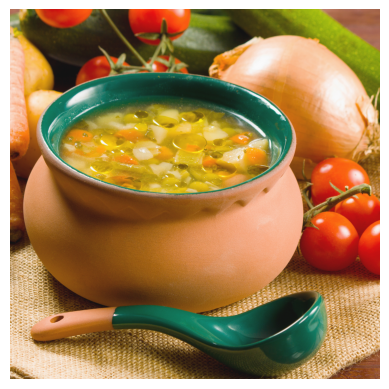

In [6]:
img_name = 'Depositphotos_18759893_XL.jpg'
img = imread(os.path.join(data_path,img_name))
h,w,c = img.shape
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
# 分割图片
N = 8 # 分成N x N个拼图块
assert h%N == 0 and w%N == 0  ,'N 无法被高宽整除'
patch_size = (h//N,w//N)
patch_size

(256, 256)

In [8]:
patch_list = []
for w_h in range(N):
    for w_w in range(N):
        patch_list.append(img[w_h*patch_size[0]:(w_h+1)*patch_size[0],w_w*patch_size[1]:(w_w+1)*patch_size[1],:])

In [9]:
# plot_any(patch_list,N)

# 特征工程

In [10]:
from skimage.feature.texture import graycomatrix, graycoprops
def extract_color_features(img):
    # 多维直方图
    h,edges = np.histogramdd(img.reshape(-1,3),3,normed=True,
                        range=[(0,255),(0,255),(0,255)])
    return h.flatten()


def extract_texture_features(image):
    # 将图像转换为灰度
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 计算LBP图像
    lbp_image = skimage.feature.local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    
    # 计算LBP直方图
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 10), range=(0, 10))
    
    # 将直方图归一化
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    # 计算GCLM特征
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)
    texture_features_cont = graycoprops(glcm, 'contrast')
    texture_features_homo = graycoprops(glcm, 'homogeneity')
    texture_features_ener = graycoprops(glcm, 'energy')
    texture_features_corr = graycoprops(glcm, 'correlation')
    
    return np.concatenate([lbp_hist,
                     texture_features_cont.flatten(),
                     texture_features_homo.flatten(),
                     texture_features_ener.flatten(),
                     texture_features_corr.flatten()])

def extract_edge_features(image):
    # 使用Canny边缘检测提取边缘特征
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)  # 调整阈值以控制边缘检测的灵敏度
    
    # 计算边缘像素的数量
    edge_pixel_count = np.sum(edges)

    # 计算边缘转角的数量
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_area = np.sum([cv2.contourArea(contour) for contour in contours])
    
    return np.array([edge_pixel_count,contour_area])

def extract_position_features(N):
    col = np.arange(N).reshape(1,-1).repeat(N,0).reshape(-1,1)
    row = np.arange(N).repeat(N,0).reshape(N,N).reshape(-1,1)

    return np.concatenate((row,col),axis=1)


In [11]:
extract_color_features(patch_list[25]).shape,extract_texture_features(patch_list[25]).shape,extract_edge_features(patch_list[25]).shape

((27,), (13,), (2,))

In [12]:
features = np.array([np.concatenate((extract_color_features(i),
                                    #  extract_texture_features(i),
                                     extract_edge_features(i))) 
 for i in patch_list ])
poi_feats = extract_position_features(N)
features = np.concatenate((features,poi_feats),axis=-1)
scalar = StandardScaler()
features = scalar.fit_transform(features)

In [18]:
features[0].shape

(31,)

In [14]:
from model import kmeans_clustering as kc
kc.search_k(4,8,features)
    
# plt.plot(range(2,11),distortions,marker='o')
# plt.show()

8

## 互信息

In [15]:
K = 6 # 聚类数量
km=KMeans(n_clusters=K,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=42)
km.fit(features)
result = km.predict(features)

In [17]:
km.cluster_centers_.shape

(6, 31)

In [16]:
import sklearn.feature_selection as fs

mir_result = fs.mutual_info_classif(features, result,random_state=0) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(features.shape[-1]):
    feature_scores.append([i,mir_result[i]])
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
np.array(sorted_scores)

array([[1.50000000e+01, 8.20894182e-01],
       [1.00000000e+00, 5.85195754e-01],
       [2.90000000e+01, 5.58245350e-01],
       [2.80000000e+01, 5.31109774e-01],
       [2.70000000e+01, 4.85107622e-01],
       [1.80000000e+01, 4.78883433e-01],
       [5.00000000e+00, 4.73846603e-01],
       [1.00000000e+01, 4.47685757e-01],
       [4.00000000e+00, 3.87300906e-01],
       [1.60000000e+01, 3.50484039e-01],
       [1.70000000e+01, 3.27582573e-01],
       [2.20000000e+01, 2.82688067e-01],
       [2.40000000e+01, 2.76432568e-01],
       [2.50000000e+01, 2.73596151e-01],
       [9.00000000e+00, 2.57419834e-01],
       [2.10000000e+01, 2.52733187e-01],
       [0.00000000e+00, 2.49159811e-01],
       [7.00000000e+00, 2.04443293e-01],
       [2.60000000e+01, 1.98892349e-01],
       [8.00000000e+00, 1.66069460e-01],
       [1.20000000e+01, 1.64144376e-01],
       [1.30000000e+01, 1.51832597e-01],
       [3.00000000e+00, 1.46158111e-01],
       [1.40000000e+01, 1.17824486e-01],
       [2.300000

## 方差阈限

In [17]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold() # Default 0
vt_features=selector.fit_transform(features)
print('过滤后的数据',vt_features.shape)
print('方差',selector.variances_)

过滤后的数据 (64, 26)
方差 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


# 聚类

In [18]:
new_feat = features # 原特征
# new_feat = features[:,np.array(sorted_scores)[:-5,0].astype(int)] # 互信息特征
# new_feat = vt_features # 方差特征

km=KMeans(n_clusters=K,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=42)
km.fit(new_feat)
result = km.predict(new_feat)

In [19]:
def detect_neighbor(clu_result,N):
    label_array = clu_result.reshape(N,N)
    new_label_array = np.zeros_like(label_array) + np.inf

    # 八个方向错位比较
    up_array = np.zeros_like(label_array) + np.inf
    up_array[:-1,:] = label_array[1:,:]
    new_label_array = np.where((label_array == up_array) , label_array,new_label_array)
    
    down_array = np.zeros_like(label_array) + np.inf
    down_array[1:,:] = label_array[:-1,:]
    new_label_array = np.where((label_array == down_array) , label_array,new_label_array)

    right_array = np.zeros_like(label_array) + np.inf
    right_array[:,1:] = label_array[:,:-1]
    new_label_array = np.where((label_array == right_array) , label_array,new_label_array)

    left_array = np.zeros_like(label_array) + np.inf
    left_array[:,:-1] = label_array[:,1:]
    new_label_array = np.where((label_array == left_array) , label_array,new_label_array)

    ur_array = np.zeros_like(label_array) + np.inf
    ur_array[:-1,1:] = label_array[1:,:-1]
    new_label_array = np.where((label_array == ur_array) , label_array,new_label_array)

    ul_array = np.zeros_like(label_array) + np.inf
    ul_array[:-1,:-1] = label_array[1:,1:]
    new_label_array = np.where((label_array == ul_array) , label_array,new_label_array)

    dr_array = np.zeros_like(label_array) + np.inf
    dr_array[1:,1:] = label_array[:-1,:-1]
    new_label_array = np.where((label_array == dr_array) , label_array,new_label_array)

    dl_array = np.zeros_like(label_array) + np.inf
    dl_array[1:,:-1] = label_array[:-1,1:]
    new_label_array = np.where((label_array == dl_array) , label_array,new_label_array)
    
    # 选择最多邻居作为新标签
    nei_array = np.concatenate((up_array[new_label_array == np.inf].reshape(1,-1),
                    down_array[new_label_array == np.inf].reshape(1,-1),
                    right_array[new_label_array == np.inf].reshape(1,-1),
                    left_array[new_label_array == np.inf].reshape(1,-1),
                    ur_array[new_label_array == np.inf].reshape(1,-1),
                    ul_array[new_label_array == np.inf].reshape(1,-1),
                    dr_array[new_label_array == np.inf].reshape(1,-1),
                    dl_array[new_label_array == np.inf].reshape(1,-1),
                    ),axis=0)
    new_labels = []
    for i in range(nei_array.shape[-1]):
        v,c = np.unique(nei_array[:,i],return_counts=True)
        tmp_max = 0
        for j,k in zip(v,c): # 如果多个最大随机选择一个
            if k > tmp_max and j != np.inf:
                tmp_max = k
                new_label = j
        new_labels.append(new_label)
    
    new_labels = np.array(new_labels)

    new_label_array[new_label_array == np.inf] = new_labels
            

    return new_label_array.reshape(-1,).astype(int)
    
    

In [20]:
final_result = detect_neighbor(result,N)
final_result.reshape(N,N)

array([[3, 3, 3, 3, 3, 3, 5, 5],
       [0, 0, 3, 3, 3, 1, 1, 1],
       [0, 0, 1, 1, 3, 1, 1, 1],
       [3, 3, 1, 1, 1, 1, 3, 1],
       [3, 3, 3, 3, 1, 1, 3, 3],
       [4, 3, 3, 1, 1, 1, 3, 3],
       [4, 3, 3, 3, 1, 2, 4, 4],
       [4, 4, 4, 4, 2, 2, 4, 4]])

In [21]:
result.reshape(N,N) == final_result.reshape(N,N)

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False,  True, False,  True, False,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [22]:
plot_any(patch_list,N,final_result)